In [1]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

# Image processing
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

# Deep learning - Keras/TensorFlow
from keras.callbacks import EarlyStopping, ModelCheckpoint

2024-04-17 12:10:59.056887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# transformation to the image dataseet:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a fixed size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()           # Convert images to PyTorch tensors and scale to [0, 1]
])

In [16]:
train_dir = './Alzheimer_s Dataset/train/'
ds_train = datasets.ImageFolder(train_dir, transform=transform)
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)

test_dir = './Alzheimer_s Dataset/test/'
ds_test = datasets.ImageFolder(test_dir, transform=transform)
dl_test = DataLoader(ds_test, batch_size=64, shuffle=False)

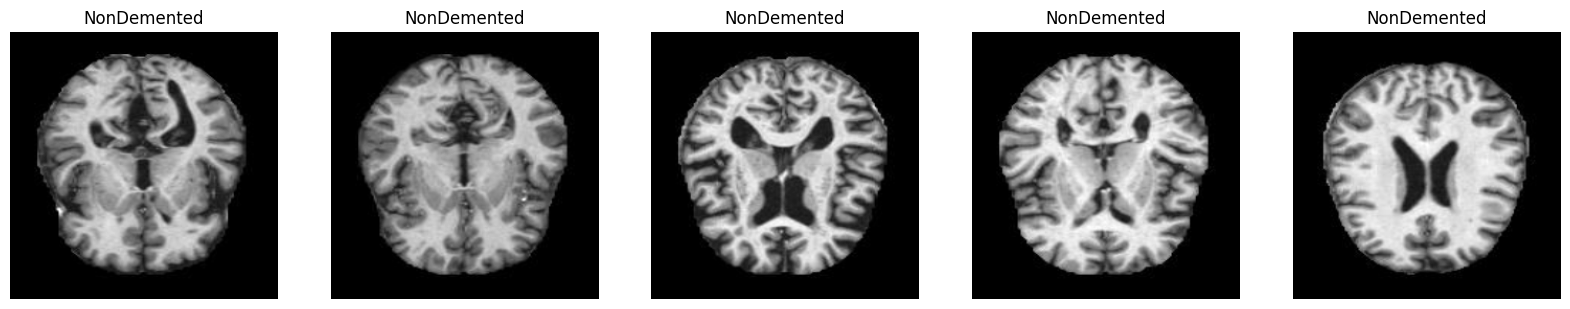

In [17]:
images, labels = next(iter(dl_train))

num_images = 5

fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

class_names = ds_train.classes

for i in range(num_images):
    axes[i].imshow(images[i].permute(1, 2, 0), cmap='gray')
    axes[i].set_title(class_names[labels[i].item()])
    axes[i].axis('off')

plt.show()


In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [19]:
model = CNN()
summary(model, input_size=(64, 1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Conv2d: 1-1                            [64, 32, 256, 256]        320
├─Conv2d: 1-2                            [64, 64, 128, 128]        18,496
├─Conv2d: 1-3                            [64, 128, 64, 64]         73,856
├─Linear: 1-4                            [64, 128]                 16,777,344
├─Linear: 1-5                            [64, 4]                   516
Total params: 16,870,532
Trainable params: 16,870,532
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 41.17
Input size (MB): 16.78
Forward/backward pass size (MB): 1879.12
Params size (MB): 67.48
Estimated Total Size (MB): 1963.38

Epoch 1/20, Train Loss: 1.1007, Val Loss: 1.0489
Epoch 2/20, Train Loss: 0.9501, Val Loss: 0.9183
Epoch 3/20, Train Loss: 0.8601, Val Loss: 0.8578
Epoch 4/20, Train Loss: 0.7653, Val Loss: 0.7101
Epoch 5/20, Train Loss: 0.5867, Val Loss: 0.5246
Epoch 6/20, Train Loss: 0.4092, Val Loss: 0.4277
Epoch 7/20, Train Loss: 0.2528, Val Loss: 0.4124
Epoch 8/20, Train Loss: 0.1572, Val Loss: 0.3427
Epoch 9/20, Train Loss: 0.1049, Val Loss: 0.2602
Epoch 10/20, Train Loss: 0.0496, Val Loss: 0.2326
Epoch 11/20, Train Loss: 0.0197, Val Loss: 0.2106
Epoch 12/20, Train Loss: 0.0339, Val Loss: 0.2766
Epoch 13/20, Train Loss: 0.0526, Val Loss: 0.2122
Epoch 14/20, Train Loss: 0.0313, Val Loss: 0.2011
Epoch 15/20, Train Loss: 0.0054, Val Loss: 0.1671
Epoch 16/20, Train Loss: 0.0013, Val Loss: 0.1755
Epoch 17/20, Train Loss: 0.0008, Val Loss: 0.1813
Epoch 18/20, Train Loss: 0.0006, Val Loss: 0.1861
Epoch 19/20, Train Loss: 0.0005, Val Loss: 0.1892
Epoch 20/20, Train Loss: 0.0004, Val Loss: 0.1926


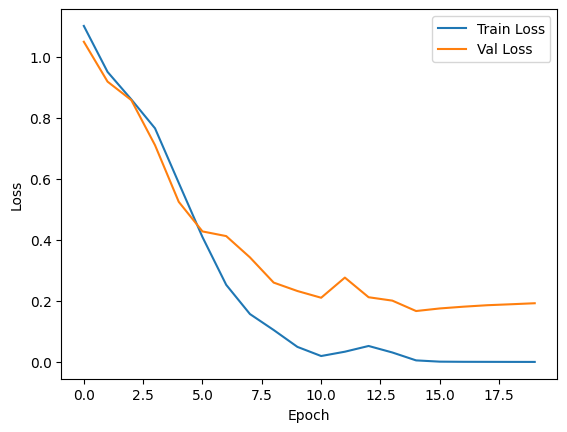

In [21]:
# split data into training, test, validation
train_size = int(0.8 * len(ds_train))
val_size = len(ds_train) - train_size

ds_train, ds_val = torch.utils.data.random_split(ds_train, [train_size, val_size])

dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=64, shuffle=False)

# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in dl_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(ds_train)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    for images, labels in dl_val:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
    val_loss /= len(ds_val)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()